In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE  


In [34]:
df = pd.read_csv("train.csv")
df.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


In [37]:
tongdong=df.shape[0]
print(tongdong)
count_8 = (df['Response'] == 8).sum()
print(count_8)
count_7=tongdong-count_8
print(count_7)



59381
19489
39892


In [38]:
numeric_cols = ['Ins_Age', 'Ht', 'Wt', 'BMI'] + [col for col in df.columns if 'Medical_Keyword' in col]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col].fillna(df[col].median(), inplace=True)

In [39]:
df['Ht'] = df['Ht'].replace(0, np.nan)
df['Wt'] = df['Wt'].replace(0, np.nan)
df['Ht'].fillna(df['Ht'].median(), inplace=True)
df['Wt'].fillna(df['Wt'].median(), inplace=True)

In [40]:
if 'BMI' in df.columns:
    print("BMI column already exists.")
else:
    df['BMI'] = df['Wt'] / (df['Ht'] ** 2)
    df['BMI'] = df['BMI'].replace([np.inf, -np.inf], np.nan).fillna(df['BMI'].median())

BMI column already exists.


In [41]:
medical_cols = [col for col in df.columns if 'Medical_Keyword' in col]
df['Medical_Keyword_Sum'] = df[medical_cols].sum(axis=1)


In [42]:
le = LabelEncoder()
df['Product_Info_2'] = le.fit_transform(df['Product_Info_2'])

In [43]:
df['BMI_Medical_Interaction'] = df['BMI'] * df['Medical_Keyword_Sum']
df['BMI_Medical_Interaction'] = df['BMI_Medical_Interaction'].clip(lower=-1e10, upper=1e10)
df['BMI_Medical_Interaction'] = df['BMI_Medical_Interaction'].replace([np.inf, -np.inf], np.nan).fillna(df['BMI_Medical_Interaction'].median())

In [44]:
df['Wt_Ht_Ratio'] = df['Wt'] / df['Ht']
df['Wt_Ht_Ratio'] = df['Wt_Ht_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(df['Wt_Ht_Ratio'].median())


In [45]:
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

In [46]:
def map_binary_response(response):
    if response in [1, 2, 3, 4, 5, 6, 7]:
        return 0
    else:  # 8
        return 1
df['Binary_Response'] = df['Response'].apply(map_binary_response)


In [47]:
print("Original Class distribution:")
print(df['Binary_Response'].value_counts(normalize=True))

Original Class distribution:
0    0.671797
1    0.328203
Name: Binary_Response, dtype: float64


In [48]:
X = df.drop(columns=['Response', 'Binary_Response'])
y = df['Binary_Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


In [49]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [50]:
print("Resampled Class distribution (Train only):")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

Resampled Class distribution (Train only):
1    0.5
0    0.5
Name: Binary_Response, dtype: float64


In [51]:
original_distribution = df['Binary_Response'].value_counts(normalize=True)
original_df = pd.DataFrame({
    'Class': ['Response 1-7 (0)', 'Response 8 (1)'],
    'Percentage': original_distribution.values
})

resampled_distribution = pd.Series(y_train_resampled).value_counts(normalize=True)
resampled_df = pd.DataFrame({
    'Class': ['Response 1-7 (0)', 'Response 8 (1)'],
    'Percentage': resampled_distribution.values
})

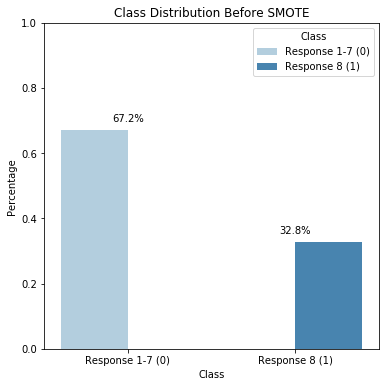

In [52]:
plt.figure(figsize=(6, 6))
sns.barplot(x='Class', y='Percentage', data=original_df, hue='Class', palette='Blues')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.ylim(0, 1)
for i, v in enumerate(original_df['Percentage']):
    plt.text(i, v + 0.02, f'{v*100:.1f}%', ha='center', va='bottom')
plt.savefig('class_distribution_before_smote.png')
plt.show()

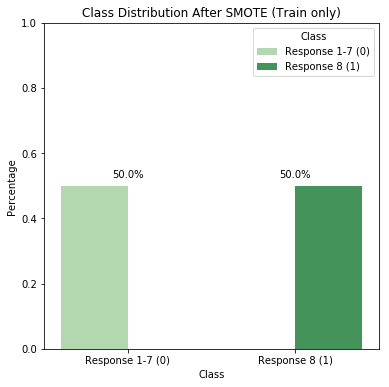

In [53]:
plt.figure(figsize=(6, 6))
sns.barplot(x='Class', y='Percentage', data=resampled_df, hue='Class', palette='Greens')
plt.title('Class Distribution After SMOTE (Train only)')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.ylim(0, 1)
for i, v in enumerate(resampled_df['Percentage']):
    plt.text(i, v + 0.02, f'{v*100:.1f}%', ha='center', va='bottom')
plt.savefig('class_distribution_after_smote_train.png')
plt.show()

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [55]:
rf_temp = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=1)
rf_temp.fit(X_train_scaled, y_train_resampled)

RandomForestClassifier(n_estimators=30, n_jobs=1, random_state=42)

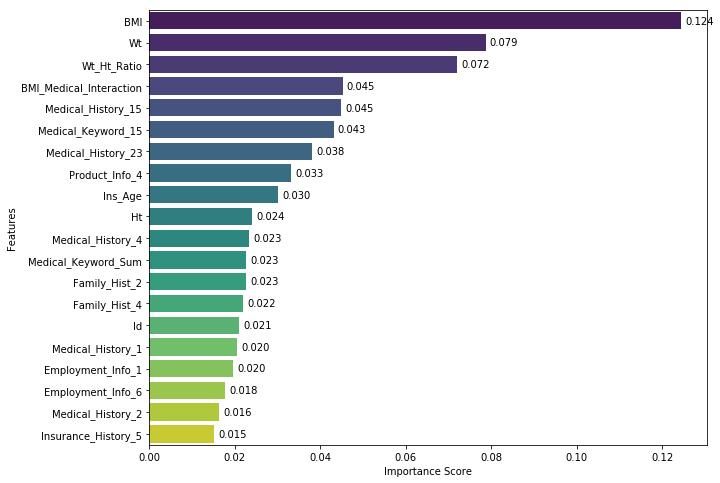

15 đặc trưng quan trọng: ['Id', 'Family_Hist_4', 'Family_Hist_2', 'Medical_Keyword_Sum', 'Medical_History_4', 'Ht', 'Ins_Age', 'Product_Info_4', 'Medical_History_23', 'Medical_Keyword_15', 'Medical_History_15', 'BMI_Medical_Interaction', 'Wt_Ht_Ratio', 'Wt', 'BMI']


In [56]:
importances = rf_temp.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Importance Score')
plt.ylabel('Features')
for i, v in enumerate(feature_importance_df['Importance']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center')
plt.savefig('feature_importance_top_20.png')
plt.show()

top_features = np.argsort(importances)[-15:]
X_train_scaled_selected = X_train_scaled[:, top_features]
X_test_scaled_selected = X_test_scaled[:, top_features]
selected_features = X.columns[top_features].tolist()
print("15 đặc trưng quan trọng:", selected_features)

In [57]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, class_weight='balanced', random_state=42, n_jobs=1)
rf_model.fit(X_train_scaled_selected, y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       n_jobs=1, random_state=42)

In [58]:
y_pred_prob = rf_model.predict_proba(X_test_scaled_selected)[:, 1]


In [59]:
thresholds = np.arange(0, 1.01, 0.05)  # 0 to 1, step 0.05
sensitivities = []
accuracies = []
precisions = []

for threshold in thresholds:
    y_pred_adjusted = (y_pred_prob >= threshold).astype(int)
    sensitivities.append(recall_score(y_test, y_pred_adjusted, zero_division=0))
    accuracies.append(accuracy_score(y_test, y_pred_adjusted))
    precisions.append(precision_score(y_test, y_pred_adjusted, zero_division=0))


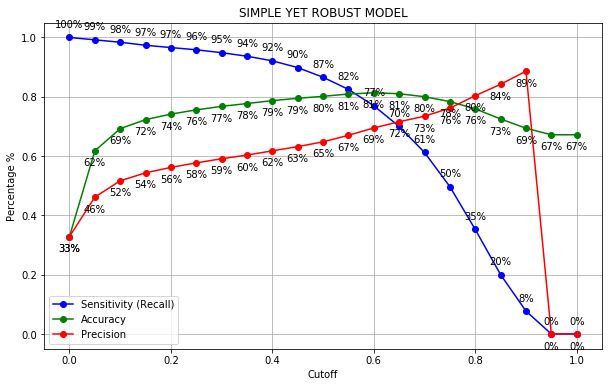

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sensitivities, label='Sensitivity (Recall)', marker='o', color='blue')
plt.plot(thresholds, accuracies, label='Accuracy', marker='o', color='green')
plt.plot(thresholds, precisions, label='Precision', marker='o', color='red')
plt.title('SIMPLE YET ROBUST MODEL')
plt.xlabel('Cutoff')
plt.ylabel('Percentage %')
plt.legend()
plt.grid(True)

for i, (s, a, p) in enumerate(zip(sensitivities, accuracies, precisions)):
    plt.annotate(f'{s*100:.0f}%', (thresholds[i], sensitivities[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(f'{a*100:.0f}%', (thresholds[i], accuracies[i]), textcoords="offset points", xytext=(0, -15), ha='center')
    plt.annotate(f'{p*100:.0f}%', (thresholds[i], precisions[i]), textcoords="offset points", xytext=(0, -15), ha='center')


In [61]:
f1_scores = []
for p, r in zip(precisions, sensitivities):
    if (p + r) > 0:
        f1 = 2 * (p * r) / (p + r)
    else:
        f1 = 0
    f1_scores.append(f1)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold (based on F1-score): {optimal_threshold:.2f}")
print(f"Sensitivity (Recall): {sensitivities[optimal_idx]:.2f}")
print(f"Accuracy: {accuracies[optimal_idx]:.2f}")
print(f"Precision: {precisions[optimal_idx]:.2f}")


Optimal Threshold (based on F1-score): 0.45
Sensitivity (Recall): 0.90
Accuracy: 0.79
Precision: 0.63



Classification Report at Optimal Threshold 0.45:
                  precision    recall  f1-score   support

Response 1-7 (0)       0.94      0.74      0.83     11968
  Response 8 (1)       0.63      0.90      0.74      5847

        accuracy                           0.79     17815
       macro avg       0.78      0.82      0.79     17815
    weighted avg       0.84      0.79      0.80     17815



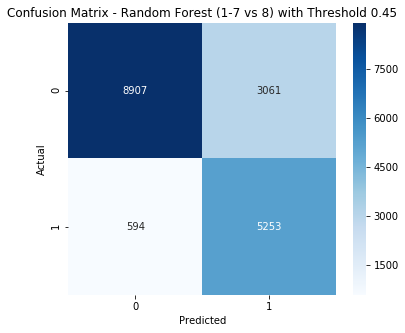

In [62]:
y_pred_adjusted = (y_pred_prob >= optimal_threshold).astype(int)
print("\nClassification Report at Optimal Threshold {:.2f}:".format(optimal_threshold))
print(classification_report(y_test, y_pred_adjusted, target_names=['Response 1-7 (0)', 'Response 8 (1)'], zero_division=0))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Random Forest (1-7 vs 8) with Threshold {optimal_threshold:.2f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_rf_1-7_vs_8_smote_optimal.png')
plt.show()